# Creating a Kaggle Workflow

In this project, I'm going to tackle a typical workflow of a Kaggle competition project in searching for the best machine learning model to use.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

In [3]:
print(holdout.head())

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  


In [4]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [5]:
def run_functions(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    columns = ['Age_categories','Fare_categories',
               'Title','Cabin_type','Sex']
    
    for col in columns:
        df = create_dummies(df, col)
    return df

In [6]:
train = run_functions(train)
holdout = run_functions(holdout)

In [7]:
print(train['SibSp'].dtype)
print(train['Parch'].dtype)

int64
int64


0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64


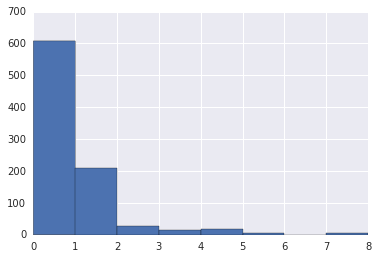

In [8]:
print(train['SibSp'].value_counts())
train['SibSp'].hist(bins=8)

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


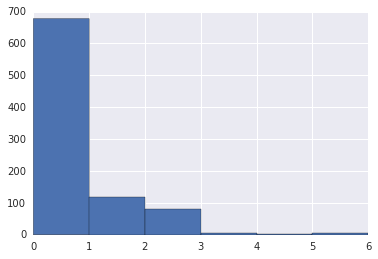

In [9]:
print(train['Parch'].value_counts())
train['Parch'].hist(bins=6)

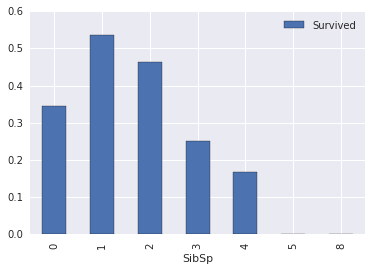

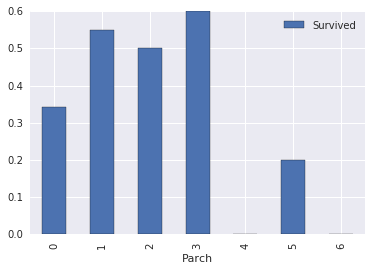

In [10]:
sibsp_pivot = train.pivot_table(index='SibSp', values='Survived')
sibsp_pivot.plot.bar()
plt.show()

parch_pivot = train.pivot_table(index='Parch', values='Survived')
parch_pivot.plot.bar()
plt.show()

For SibSp, it looks like we could group the values together in the following format:

- 0
- 1
- 2
- 3+

For Parch, it seems that we can group it as the following:

- 0
- 1
- 2
- 3
- 4+

It appears that only 30% of passengers who had no family members onboard survived.

In [11]:
def is_alone(df):
    df['family'] = df[['SibSp','Parch']].sum(axis=1)
    df['isalone'] = 0
    df.loc[(df['family'] == 0),'isalone'] = 1
    return df

train = is_alone(train)
holdout = is_alone(holdout)

In [12]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(columns=['PassengerId','Survived'])
    all_y = df['Survived']
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_y)
    optimized_columns = all_X.columns[selector.support_].tolist()
    print(optimized_columns)
    return optimized_columns
    
best_features = select_features(train)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'family', 'isalone']


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_models(df, feature_list):
    all_X = df[feature_list]
    all_y = df['Survived']
    model_list = [{
        "name": "LogisticRegression",
        "estimator": LogisticRegression(),
        "hyperparameters":
        {
            "solver": ["newton-cg","lbfgs", "liblinear"]
        }
    },
    {
        "name": "KNeighborsClassifier",
        "estimator": KNeighborsClassifier(),
        "hyperparameters":
            {
                "n_neighbors": range(1,20,2),
                "weights": ['distance', 'uniform'],
                "algorithm": ['ball_tree','kd_tree','brute'],
                "p": [1,2]
            }
    },
    {
        "name": "RandomForestClassifier",
        "estimator": RandomForestClassifier(),
        "hyperparameters":
        {
            "n_estimators": [4,6,9],
            "criterion": ['entropy','gini'],
            "max_depth": [2,5,10],
            "max_features": ['log2','sqrt'],
            "min_samples_leaf": [1,5,8],
            "min_samples_split": [2,3,5]
        }
    }]
    
    for model in model_list:
        print(model['name'])
        grid = GridSearchCV(model['estimator'],
                            param_grid=model['hyperparameters'],
                           cv=10)
        grid.fit(all_X,all_y)
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_
        model['best_model'] = grid.best_estimator_
        
        print('Best Score: {}'.format(model['best_score']))
        print('Best Parameters: {}\n'.format(model['best_params']))
        
    return model_list

model_results = select_models(train, best_features)

LogisticRegression
Best Score: 0.8181818181818182
Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
Best Score: 0.7800224466891134
Best Parameters: {'algorithm': 'kd_tree', 'n_neighbors': 3, 'weights': 'uniform', 'p': 1}

RandomForestClassifier
Best Score: 0.8406285072951739
Best Parameters: {'min_samples_split': 2, 'criterion': 'gini', 'max_depth': 10, 'n_estimators': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1}



In [15]:
def save_submission_file(model, columns, filename='default.csv'):
    holdout_predictions = model.predict(holdout[columns])
    holdout_ids = holdout['PassengerId']
    submission_df = {'PassengerId': holdout_ids,
                    'Survived': holdout_predictions}
    submission = pd.DataFrame(submission_df)
    submission.to_csv(filename)
    
best_rf_model = model_results[2]['best_model']
save_submission_file(best_rf_model, best_features, 'submission.csv')